# Introduction to the jupyter notebook



* The selected resolution (by default 256*256 is hard coded)
* The notebook was created on Google Colab and set up to import data from google drive
* The U-Net's architecture was derived from the following notebook: [Road maps from Aerial Images](https://www.kaggle.com/vanvalkenberg/road-maps-from-aerial-images)



## Installing librairies and packages

In [2]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import IPython.display as display
from PIL import Image
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses

from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.ndimage import gaussian_filter
from tensorflow.keras import backend
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split


In [3]:
#Installing TFA to apply the gaussian filter
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons import image
from tensorflow_addons.image import gaussian_filter2d

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the data from Google Drive

In [5]:
#Selecting the number of images to import
number_images = 100

#Connecting to drive
images_list = os.listdir('/content/drive/MyDrive/TropicalForestRoadDetectors/Kaggle/Dataset_1_Deep_globe/train/') #Extract the name of the images
images_dict = {}

#Extract the images, reshape them and add them to a dictonnary 
for image in images_list[:number_images] : 
  Myimage = Image.open('/content/drive/MyDrive/TropicalForestRoadDetectors/Kaggle/Dataset_1_Deep_globe/train/'+image)
  Myimage = Myimage.resize((256,256),Image.ANTIALIAS)
  if 'mask' in image:
       thresh = 128
       fn = lambda x : 255 if x > thresh else 0
       Myimage = Myimage.convert(mode='L').point(fn, mode='1')
  image_array = np.array(Myimage)
  images_dict[image] = image_array

#create directory for masks and raw images
dir_mask = []
dir_img = []

for key in images_dict.keys():
  if 'mask' in str(key):
    dir_mask.append(images_dict[key])
  if 'sat' in str(key):
    dir_img.append(images_dict[key])

# Defining the model and its architecture

In [6]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x
# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 64, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 2, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 2, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 2, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

# Data processing

In [7]:
#Converting the boolean to 1s and 0s
dir_mask = np.array(dir_mask).astype('float32')
dir_img = np.array(dir_img).astype('int64')

In [8]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(dir_img, dir_mask, test_size=0.2, random_state=1)

In [9]:
#Adding to the black and white masks a dimension 
y_train = y_train.reshape((X_train.shape[0], 256, 256, 1))
y_test = y_test.reshape((X_test.shape[0], 256, 256, 1))

In [10]:
#Padding X
pad=pad_sequences(X_train)

# Defining the metrics and losses


In [11]:
#Function to binarize the pred before applying them the gaussian blur
def binarize(array, threshold):
    tmp = tf.convert_to_tensor(array)
    tmp = tf.cast(tf.math.greater(tmp, threshold), 'float32')
    return tmp

In [12]:
#Custom IoU metric
def metrics_continuous_iou(y_true, y_pred, sigma=(4.0, 4.0)):

    y_true = tf.cast(tf.convert_to_tensor(y_true), 'float32')
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), 'float32')

    bin_pred = binarize(y_pred, .5)

    gf_true = tfa.image.gaussian_filter2d(y_true, sigma=sigma)
    gf_pred = tfa.image.gaussian_filter2d(bin_pred, sigma=sigma)

    y_true = tf.cast(gf_true, dtype='float32')
    y_pred = tf.cast(gf_pred, dtype='float32')
    
    return tf.math.reduce_sum(tf.math.abs(tf.math.subtract(gf_true, gf_pred))) / tf.math.reduce_sum(y_true + bin_pred)

In [13]:
#MAE with gaussian filter
def custom_mae(y_true, y_pred):
  
    gf_pred = gaussian_filter2d(y_pred, sigma=4)
    gf_true = gaussian_filter2d(y_true, sigma=4)
    # gf_true = y_true

    loss = metrics.mean_absolute_error(y_true=gf_true, y_pred=gf_pred)
    return loss

In [14]:
#Binary crossentropy with gaussian filter
def binary_crossentropy_gaussian(y_true, y_pred):
    gf_pred = gaussian_filter2d(y_pred, sigma=4)
    gf_true = tf.constant(y_true, dtype='float')

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss = bce(gf_true, gf_pred)
    return loss

In [16]:
#KLD with gaussian filter
def KLDivergence_gaussian(y_true, y_pred):
    gf_pred = gaussian_filter2d(y_pred, sigma=4)
    gf_true = tf.constant(y_true, dtype='float')

    kld = tf.keras.losses.KLDivergence()
    loss = kld(gf_true, gf_pred)
    return loss

In [15]:
#New custom loss
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, 'float32')
    y_pred_bin = tf.round(y_pred)
    y_pred = (y_pred - (tf.stop_gradient(y_pred) - y_pred_bin))
    intersection = tf.reduce_sum(tf.abs(y_true) * tf.abs(y_pred))
    sum_ = tf.reduce_sum(tf.abs(y_true) + tf.abs(y_pred))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Baseline



In [ ]:
#Function to define the baseline
import math
import random

def baseline_generation(resolution):

    #The goal is to create a matrix with the shape of the images' dimensions filled with as many ones as there is on average in the y_train
    pixel_count = round(y_train.sum() / (y_train.shape[0] * y_train.shape[1] * y_train.shape[2]) * (resolution*resolution))
    base_array = []

    #Starts by creating a list of the correct number of ones
    for k in range(pixel_count):
        base_array.append(1)

    #Then add the zeros
    for a in range((resolution*resolution) - pixel_count):
        base_array.append(0)

    #Convert to array, randomize the distribution of ones and convert to correct dimension
    base_array = np.array(base_array)
    np.random.shuffle(base_array)
    base_array = base_array.reshape(resolution, resolution)

    return base_array

In [ ]:
#Testing the baseline
y_true = y_test
y_baseline = baseline_generation(256)
list_iou = []
list_custom_iou = []
list_custom_mae = []
for i in range(len(y_true)):
    list_custom_iou.append(float(metrics_continuous_iou(y_true[i], y_baseline.reshape(256, 256, 1))))


print("Baseline Custom IoU: ", np.mean(list_custom_iou))

Baseline IoU:  0.01698552611109335


#Compiling and running the model

In [17]:
##Decaying learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=5000, decay_rate=0.7)

## instantiating model
inputs = tf.keras.layers.Input((256, 256, 3))

unet = GiveMeUnet(inputs, droupouts= 0.07)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
unet.compile(optimizer = adam, loss = binary_crossentropy_gaussian, metrics=[metrics_continuous_iou, custom_mae], run_eagerly=True)

In [ ]:
#Fitting the model
es = EarlyStopping(patience=20, restore_best_weights=True)

retVal = unet.fit(pad, y_train,
                  validation_split=0.2, 
                  epochs = 200, 
                  verbose = 1,
                  batch_size=16,
                  callbacks=[es])

#Model evaluation: plotting, evaluating, visualizing

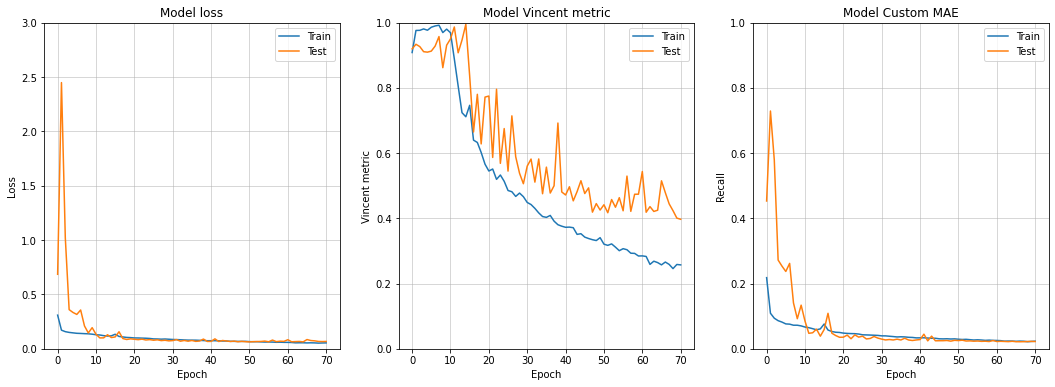

In [ ]:
#Plotting
def plot_loss(history, title=None):
    fig, ax = plt.subplots(1,3, figsize=(18,6))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- Precision
    
    ax[1].plot(history.history['metrics_continuous_iou'])
    ax[1].plot(history.history['val_metrics_continuous_iou'])
    ax[1].set_title('Model Vincent metric')
    ax[1].set_ylabel('Vincent metric')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- Recall
    
    ax[2].plot(history.history['custom_mae'])
    ax[2].plot(history.history['val_custom_mae'])
    ax[2].set_title('Model Custom MAE')
    ax[2].set_ylabel('Recall')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Test'], loc='best')
    ax[2].set_ylim((0,1))
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)

plot_loss(retVal)

In [ ]:
#Evaluating
unet.evaluate(pad_sequences(X_test), y_test, verbose=1)

4/4 [==============================] - 1s 354ms/step - loss: 0.0630 - metrics_continuous_iou: 0.4088 - custom_mae: 0.0253


[0.06302106380462646, 0.4088272750377655, 0.025349559262394905]

In [ ]:
#Define the prediction and plotting functions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    test_shape = y_test.shape[0]
    img = valMap['img'][0:test_shape]
    mask = valMap['mask'][0:test_shape]    
    imgProc = img [0:test_shape]
    imgProc = np.array(img)
    predictions = model.predict(imgProc)
    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')

In [ ]:
#Creating a dictionnary with the test satellite images and masks
test_shape = y_test.shape[0]
TestObj = {'img':np.array(X_test), 'mask':np.array(y_test).reshape(test_shape, 256, 256)}
sixteenPrediction, actuals, masks = predict16(TestObj, unet)

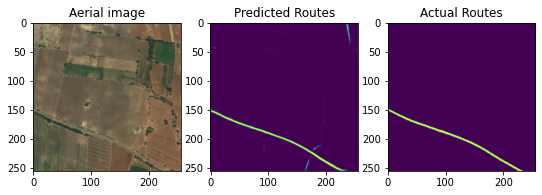

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

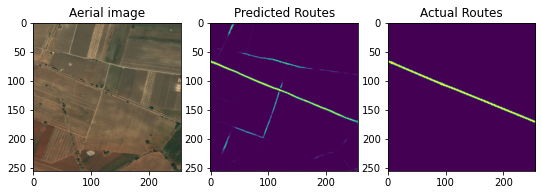

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

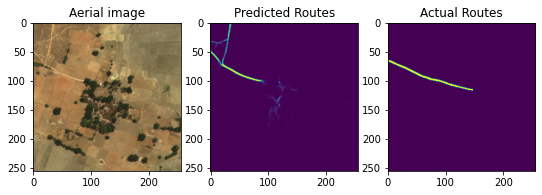

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

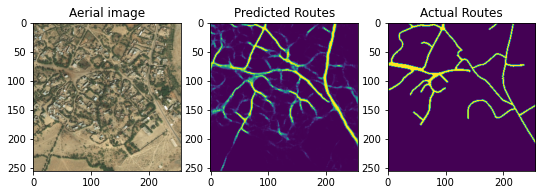

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

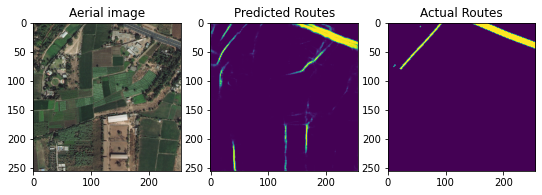

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

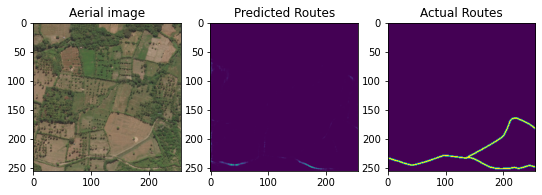

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

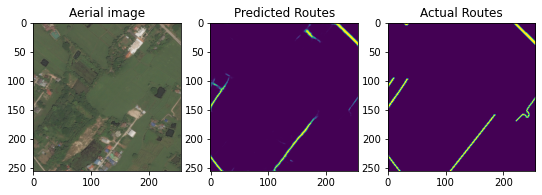

In [ ]:
#Plotting a few images and their predictions
Plotter(actuals[12], sixteenPrediction[12][:,:,0], masks[12])

# Binarize & resize the predictions

In [19]:
def binarize_predictions(pred, threshold=0.5):
    #Binarize the prediction based on if above or below a given threshold (default = 0.5)
    dimension = pred.shape[0]
    new_pred = []
    #vectorize
    pred = list(pred.reshape(dimension*dimension))
    #binarize the vector
    for pixel in pred:
        if pixel > threshold:
            new_pred.append(255)
        else:
            new_pred.append(0)

    new_pred = np.array(new_pred).reshape(dimension, dimension)
    return new_pred

In [20]:
def display_resized_prediction(pred):
    #Resize the image in 526, 526 & display it
    image = Image.fromarray((pred).astype(np.uint8))
    image = image.resize((526, 526))
    image = np.array(image)
    return image

#Saving the model

In [ ]:
#Saving the model to the drive
unet.save('/content/drive/MyDrive/TropicalForestRoadDetectors/Model/Entire_Dataset_RouteGenerator.h5')
unet.save_weights('/content/drive/MyDrive/TropicalForestRoadDetectors/Model/Entire_Dataset_RouteGenerator_weights.h5')